In [1]:
import numpy as np
from matplotlib    import pyplot as plt
from numpy.random  import default_rng
from tqdm          import tqdm
from time          import perf_counter 
from scipy.stats   import pearsonr, poisson, multivariate_normal, norm, vonmises, multivariate_t, rice
from scipy.special import laguerre, i0, i1
# from dw_tools      import multivariatet as mvt

In [2]:
plt.rcParams.update({'font.size': 14})

## Introduction
Consider a pair of normalized structure factors $\left(E_1, E_{3}\right)$, with $E_1=(E_{1x}, E_{1y})$, and $E_{3}=(E_{3x}, E_{3y})$. Under the double-Wilson model, their distribution is jointly normal, $\sim N\left((0,0,0,0),C\right)$, with 

$$
C = 
\frac{\Sigma}{2}
\begin{bmatrix}
1 & 0 & r & 0 \\
0 & 1 & 0 & r \\
r & 0 & 1 & 0 \\
0 & r & 0 & 1  
\end{bmatrix}
$$

This can be ON and OFF, or ES and GS. The notation is such that $\left<|E_1|^2\right>=\left<E_{1x}^2+E_{1y}^2\right>=\Sigma$. For actual normalized structure factors, rather than $F$'s, $\Sigma=1$.

A word on notation: ```r``` and ```rx``` below both refer to $r$ above: they are correlation coefficients between real or imaginary components of two structure factors. I use ```r``` to refer to correlation with a reference data set from another crystal, and ```rx``` for correlations expected within a crystal, in particular between ground and excited states.

### Conditioning on a known structure factor amplitude
Now, let's examine what happens when we know one of the structure factors, e.g. $E_3$ (note that we can set one of the phases, e.g., $\phi_3$ to 0, or any other number, without loss of generality). When we have a known value for $E_3=(E_{3,x}, E_{3,y})$, the conditional distribution of $E$ becomes a bivariate normal with mean $\mu = r E_{3}$, with $r$ playing the role of $r_{DW}$ in the double-wilson model, and covariance matrix 

$$C_{1|3} = \frac{\Sigma}{2}
\begin{bmatrix}
1-r^2 & 0 \\
0 & 1-r^2
\end{bmatrix}
$$

It is helpful to write this in polar coordinates using $E_1 = R_1 \left(\cos(\phi_1),\sin(\phi_1)\right)$ and $\mu = r E_3 = R_3 \left(\cos(\phi_3),\sin(\phi_3)\right)$, such that

$$
\begin{align}
P\left(R_1,\phi_1 | R_3, \phi_3\right) & =  R_1 \frac{1}{2 \pi \sqrt{\det(C_{1|3})}} * 
                                       \exp\left(
                                           -\frac{1}{2}
                                           \left(R_1\cos(\phi_1)-R_3\cos(\phi_3), 
                                                 R_1\sin(\phi_1)-R_3\sin(\phi_3)
                                           \right)
                                           C_{1|3}^{-1}
                                           \left(R_1\cos(\phi_1)-R_3\cos(\phi_3), 
                                                 R_1\sin(\phi_1)-R_3\sin(\phi_3)
                                           \right)^T
                                       \right)\\
                                       & = 
                                       R_1 \frac{1}{2 \pi \sqrt{\det(C_{1|3})}} * 
                                       \exp\left(
                                           -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                           +\frac{R_1 R_3 (\cos(\phi_1)\cos(\phi_3)-
                                                                      \sin(\phi_1)\sin(\phi_3))}
                                                            {\Sigma(1-r^2)}          
                                           \right) \\
                                       & = 
                                        \frac{R_1}{\pi \Sigma (1-r^2)}  
                                       \exp\left(
                                           -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                           +\frac{R_1 R_3 \cos(\phi_1-\phi_3)}{\Sigma(1-r^2)}          
                                           \right)
\end{align}                                           
$$

where we use that $C_{1|3}^{-1} = \frac{2}{\Sigma} \frac{1}{1-r^2}$ and $\det(C_{1|3}) = \left(\frac{\Sigma}{2}(1-r^2)\right)^2$. Note, again, that the definition of $R_3$ above has $r$ absorbed in it.

We can marginalize over $\Delta\phi = \phi_1-\phi_3$,

$$
\begin{align}
P\left(R_1 | R_3\right) & = \int_{0}^{2\pi} d\Delta\phi
                                 \frac{R_1}{\pi \Sigma (1-r^2)} * 
                                 \exp\left(
                                     -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                     +\frac{R_1 R_3 \cos(\Delta\phi)}{\Sigma(1-r^2)}          
                                 \right) \\
                        & = \frac{2 R_1}{\Sigma (1-r^2)} 
                                 \exp\left(
                                     -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                 \right)
                            I_0\left(
                                \frac{2 R_1 R_3}{\Sigma(1-r^2)}          
                            \right)
\end{align}                                           
$$

which is the Rice distribution. For comparison to Bricogne (1999), his $R_B$ is our $R_1$, his $r_B$ is our $R_3=r|E_3|$, and his $\Sigma_B$ is $\frac{\Sigma}{2}(1-r^2)$, our per-term conditional variance (I added the $B$ subscripts to indicate "Bricogne").

Let's consider sampling from the joint distribution first:

In [ ]:
rng = default_rng()
rx  = 0.95
mean = np.array([0,0,0,0])
cov = 0.5*\
    np.asarray([[ 1, rx, 0,  0 ],\
                [rx, 1,  0,  0 ],\
                [0,  0,  1,  rx],\
                [0,  0,  rx, 1 ]])
vals  = rng.multivariate_normal(mean,cov,100000)

**Or**, sampling from a joint conditional distribution, conditional on some other structure factor both structure factors of interest are correlated with (see section 2 of **6_Bivariate_conditional_amplitude_phase_dists**):

In [ ]:
rng = default_rng()
r   = 0.7
rx  = 0.9
mean= np.asarray([0.5,0.5,0,0])
cov = 0.5*\
      np.asarray([[ 1-r**2, rx-r**2, 0,      0],\
                  [rx-r**2, 1 -r**2, 0,      0],
                  [0,       0,       1 -r**2, rx-r**2],\
                  [0,       0,       rx-r**2, 1 -r**2]])
vals  = rng.multivariate_normal(mean,cov,100000)

In the random-diffuse Coppens model, identifying the ground-state structure factors $E^{off}=E^{gs}$ with $E_1$, and the excited-state structure factors $E^{es}$ with $E_3$,

$E^{on} = p E^{es} + (1-p) E^{gs}$

In [ ]:
p = 0.2
E_gs   = vals[:,0] + 1j * vals[:,2]
E_es   = vals[:,1] + 1j * vals[:,3]
E_off  = E_gs
E_on   = (1-p)*E_gs + p*E_es
phi_on = np.angle(E_off)
phi_off= np.angle(E_on)
E_off_abs = np.abs(E_off)
E_on_abs  = np.abs(E_on)

**Or**, we can directly sample $E^{es}$ given $E^{gs}$ (with $\phi^{gs}=0$ without loss of generality):

In [70]:
rng  = default_rng()
rx   = 0.95
p    = 0.2
E_gs = 1 + 1j*0

mean= rx * np.asarray([np.real(E_gs),np.imag(E_gs)])
cov = 0.5*np.asarray([[ 1-rx**2,        0],\
                      [0,        1 -rx**2]])
vals  = rng.multivariate_normal(mean,cov,10000)

E_es   = vals[:,0] + 1j * vals[:,1]
E_off  = E_gs
E_on   = (1-p)*E_gs + p*E_es
phi_on = np.angle(E_off)
phi_off= np.angle(E_on)
E_off_abs = np.abs(E_off)
E_on_abs  = np.abs(E_on)

### Criteria for difference maps:
We want to achieve two objectives:
- minimize map MSE error relative to the true difference map
- minimize absolute correlation with the OFF map


Does it make sense to minimize absolute correlation with the ground state? We observe that under the double-Wilson model, the expected value of $E^{on}=pE^{es}+(1-p)E^{gs}$, 

$$\mathbb{E}(E^{on})=\left(1-p+pr_{DW}\right)E^{off} = \left(1-p(1-r_{DW})\right)E^{off} = \left(1-\theta\right)E^{off}$$

which defines $\theta=p(1-r_{DW})$. The expected amplitude, $\mathbb{E}(|E^{on}|)$, is given by the mean of the corresponding Rice distribution (yielding an expression which is numerically very close to $(1-\theta)$. This expected amplitude is smaller than $|E^{off}|$ (except when $p=0 \ or\ p=1\ or\ r_{DW}=1$). This is a real effect, in principle observable in diffraction patterns. Crystal heating is a special case of the same effect. In difference maps, this effect shows up as negative covariance with the ground state. This is indeed true: the ground state is depleted in time-resolved X-ray experiments.

There may, however, be cases in which removal of correlation with the OFF map _is_ desirable. (are there really? it did seem obvious when doing the ratiometric analysis where we had to contend with inherent biases in ratio estimates). We'll examine that here.

#### MSE map error and Covariance with another map
Let's examine the case of two sets of structure factors, $F=(A,B)$ and $F'=(A',B')$ such that

$$\rho(x) = \sum_h A_h \cos(2\pi hx) + B_h \sin(2 \pi hx)$$ and likewise for $\rho'(x)$ are the corresponding maps.
Then,

$$\Delta \rho(x) = \rho'(x) - \rho(x) = \sum_h \Delta A_h \cos(2\pi hx) + \Delta B_h \sin(2 \pi hx)$$ 
with $\Delta A = A'-A$ etc. is their difference map.

The variance of this difference map is given by: 

$$Var(\Delta \rho) = \int_0^L dx (\Delta \rho(x))^2 = \int^L_0 dx \left(\sum_h \Delta A_h \cos(2\pi hx) + \Delta B_h \sin(2 \pi hx)\right)^2 = \frac{L}{2}\sum_h \left((\Delta A_h)^2 + (\Delta B_h^2)\right)$$ 

where we take into account that the mean value of $\cos^2$ or $\sin^2$ for sines and cosines that fit in the box an integer number of times, and that all other cross terms average to 0.

The covariance between two maps (e.g., $\rho(x)$ and $\Delta \rho(x)$) goes as 

$$Cov(\rho,\Delta \rho)=\int dx \rho(x) \Delta \rho(x) = \int dx \left(\sum_h \Delta A_h \cos(2\pi hx) + \Delta B_h \sin(2 \pi hx)\right)\left(\sum_h A_h \cos(2\pi hx) + B_h \sin(2 \pi hx)\right) = \frac{L}{2}\sum_h (A\Delta A_h + B\Delta B_h)$$ 
by the same arguments.

#### Application to difference maps
Applying this to our simulated data, we want to find scale coefficients $k$, $k'$ such that

- we minimize MSE between the approximate map $(k |F^{on}| - k'|F^{off}|)\exp(i\phi^{off})$, and the true map $F^{es} - F^{off}$


- we minimize (absolute) covariance of $(k |F^{on}| - k'|F^{off}|)\exp(i\phi^{off})$ with $F^{off}$

In [166]:
def calc_MSE(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, scale_by_p=True):
    '''
    As described above, this function calculates the expected mean square error (MSE) between a naive estimator 
    of the difference map and the true difference map. Measurement errors are not considered.
    '''
    if scale_by_p:
        pscale = p
    else:
        pscale = 1
    deltaF_off_phased = (k[0]*E_on_abs - k[1]*E_off_abs)*np.exp(1j*phi_off)
    MSE = np.mean(np.abs(deltaF_off_phased - pscale*(E_es-E_gs))**2)
    return MSE

def calc_Cov_off(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs):
    '''
    This function calculates the expected covariance between a estimates of the difference map 
    and the OFF map. Measurement errors are not considered.
    '''
    deltaF_off_phased = (k[0]*E_on_abs - k[1]*E_off_abs)*np.exp(1j*phi_off)
    Cov_off = np.mean(np.real(deltaF_off_phased) * np.real(E_gs)+\
                      np.imag(deltaF_off_phased) * np.imag(E_gs)\
                     )
    return Cov_off

def calc_Corr_true(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs):
    '''
    This function calculates the expected correlation between estimates of the difference map 
    and the OFF map. Measurement errors are not considered.
    '''
    deltaF_off_phased = (k[0]*E_on_abs - k[1]*E_off_abs)*np.exp(1j*phi_off)
    Cov_off = np.mean(np.real(deltaF_off_phased) * np.real(E_es-E_gs)+\
                      np.imag(deltaF_off_phased) * np.imag(E_es-E_gs)\
                     )
    norm1 = np.mean(np.abs(deltaF_off_phased)**2)
    norm2 = np.mean(np.abs(E_es-E_gs)**2)
    return Cov_off/(np.sqrt(norm1*norm2))

def calc_mean_DoM(k, E_on_abs, E_off_abs):
    DoM = (k[0]*E_on_abs - k[1]*E_off_abs)
    return np.mean(DoM)

#### Initial optimization for $k$ and $k'$.

In [10]:
nmax = 100
MSE_obs     = np.zeros((nmax,nmax))
cov_off_obs = np.zeros((nmax,nmax))
corr_true   = np.zeros((nmax,nmax))
mean_DoM    = np.zeros((nmax,nmax))
k_range = np.linspace(0.8,1.2,nmax)/p
for k1 in tqdm(range(0,nmax)):
    for k2 in range(0,nmax):
        k = [k_range[k1],k_range[k2]]
        MSE_obs[    k1,k2] = calc_MSE(      k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, scale_by_p=False)
        cov_off_obs[k1,k2] = calc_Cov_off(  k, E_on_abs, phi_off, E_off_abs, E_es, E_gs)
        corr_true[k1,k2]   = calc_Corr_true(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs)
        mean_DoM[   k1,k2] = calc_mean_DoM( k, E_on_abs, E_off_abs)

100%|████████████████████████████████████████| 100/100 [00:17<00:00,  5.67it/s]


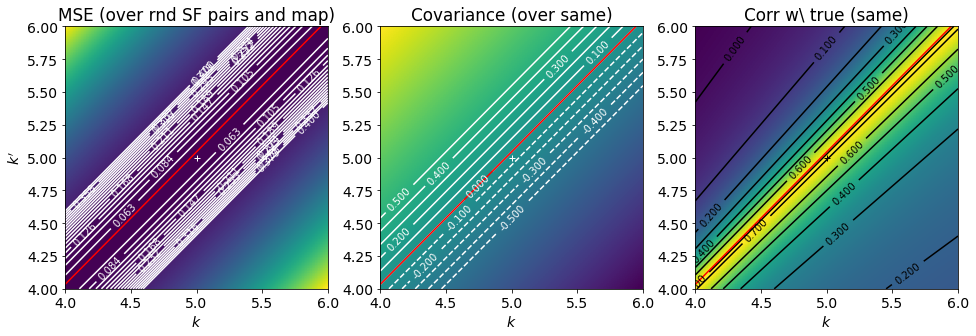

In [11]:
fig, _axs = plt.subplots(nrows=1, ncols=3,figsize=(16,5))
extent = [k_range[0], k_range[-1], k_range[0], k_range[-1]]
axs = _axs.flatten()

axs[0].imshow(MSE_obs, origin='lower', extent=extent)
cs = axs[0].contour(MSE_obs,levels=np.linspace(0.0,0.4,20),colors='w', extent=extent)
axs[0].clabel(cs, inline=True, fontsize=10)
axs[0].plot(1/p,1/p,'w+')
axs[0].set_title("MSE (over rnd SF pairs and map)")
axs[0].set_xlabel(r"$k_{on}$") # validated
axs[0].set_ylabel(r"$k_{off}'$")

axs[1].imshow( np.abs(cov_off_obs), origin='lower', extent=extent)
cs=axs[1].contour(cov_off_obs,levels=np.linspace(-0.5,0.5,11),colors='w', extent=extent)
axs[1].clabel(cs, inline=True, fontsize=10)
axs[0].contour(cov_off_obs,levels=[0],colors='r', extent=extent)
axs[1].contour(cov_off_obs,levels=[0],colors='r', extent=extent)
axs[1].plot(1/p,1/p,'w+')
axs[1].set_title("Covariance (over same)")
axs[1].set_xlabel(r"$k$")
axs[1].set_xlim(k_range[[0,-1]])
axs[1].set_ylim(k_range[[0,-1]])

axs[2].imshow( corr_true, origin='lower', extent=extent)
cs=axs[2].contour(corr_true,levels=np.linspace(-1,1,21),colors='k', extent=extent)
axs[2].clabel(cs, inline=True, fontsize=10)
axs[2].contour(cov_off_obs,levels=[0],colors='r', extent=extent)
axs[2].plot(1/p,1/p,'k+')
axs[2].set_title("Corr w\ true (same)")
axs[2].set_xlabel(r"$k$")
plt.show()

Conclusions (again, without measurement error)
- The 0-covariance line goes, in good approximation, through the origin. That is, we only care about the $k/k'$ ratio and can set $k'=1/p$ for most purposes. Indeed, $k' = 1/p$ can yield (close to) minimal MSE (white plus signs in center of each image). This reduces the problem to 1D optimization.
- The 0-covariance line goes nearly through the point of minimum MSE: one can eliminate correlation with the OFF map without much loss of accuracy.


#### 1D optimization
In this version, we set $k'=1$ and multiply the true difference map by $p$. This speeds things up a lot. That is, we optimize the approximate difference map $(k |F^{on}| - |F^{off}|)\exp(i\phi^{off})$, relative to the map $p(F^{es} - F^{off})$. 

To reduce scrolling, we repeat the sample generation code here:

In [12]:
rx   = 0.9
p    = 0.3
E_gs = 4 + 1j*0

mean= rx * np.asarray([np.real(E_gs),np.imag(E_gs)])
cov = 0.5*np.asarray([[ 1-rx**2,        0],\
                      [0,        1 -rx**2]])
vals  = rng.multivariate_normal(mean,cov,100000)

E_es   = vals[:,0] + 1j * vals[:,1]
E_off  = E_gs
E_on   = (1-p)*E_gs + p*E_es
phi_on = np.angle(E_off)
phi_off= np.angle(E_on)
E_off_abs = np.abs(E_off)
E_on_abs  = np.abs(E_on)

In [13]:
nmax = 200
MSE_obs     = np.zeros((nmax,1))
cov_off_obs = np.zeros((nmax,1))
mean_DoM    = np.zeros((nmax,1))
k_range = np.linspace(0.8,1.2,nmax)
for k1 in tqdm(range(0,nmax)):
    k = [k_range[k1],1]
    MSE_obs[k1]     = calc_MSE(    k, E_on_abs, phi_off, E_off_abs, E_es, E_gs)
    cov_off_obs[k1] = calc_Cov_off(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs)
    mean_DoM[k1]    = calc_mean_DoM(k, E_on_abs, E_off_abs)

100%|████████████████████████████████████████| 200/200 [00:03<00:00, 63.00it/s]


In [14]:
def lag_pol(x):
    result = np.exp(x/2)*((1-x)*i0(-x/2)-x*i1(-x/2))
    return result
def rice_mean(nu,sigma):
    '''The scipy stats version sometimes produces NaNs unnecessarily'''
    result = sigma*np.sqrt(np.pi/2)*lag_pol(-nu**2/(2*sigma**2))
    return result

# the following code establishes that the Laguerre(1/2) polynomial behaves approximately as 9/8*sqrt(-x).
# unfortunately, this approximation is too crude to be helpful. Some plt.show(), plt.legend() omitted for brevity
# x = -np.logspace(0,3,100)
# plt.plot(x,lag_pol(x),label="Lag. pol.")
# plt.plot(x,1.125*np.sqrt(-x),label="fit")
# plt.plot(x,lag_pol(x)-1.125*np.sqrt(-x),label="residual")

Under the double-wilson model, we can calculate the expected values of OFF and ON structure factors given their correlation and the excited state fraction. This code only makes sense for the case where we've sampled $E^{es}$, and therefore $E^{on}$ given $E^{off}$.

#### Proposed correction factor:

In [15]:
cond_mean   = np.abs(E_gs) * (1-p*(1-rx))
print(f"Expected conditional mean: {cond_mean:.3f}, and observed sample avg from the conditional dist: {np.mean(E_on):.3f}.\n")

nu          = cond_mean            
cond_var_ac = 0.5*p**2*(1-rx**2)
print(f"Expected conditional variance per component: {cond_var_ac:.5f}, and sample cond variances (real, imag):\
 ({np.var(np.real(E_on)):.5f}, {np.var(np.imag(E_on)):.5f}).\n")

sigma_ac    = np.sqrt(cond_var_ac) 
b           = nu/sigma_ac
scale       = sigma_ac

k_expected = np.abs(E_gs)/rice.mean(b=b, scale=scale)
if np.isnan(k_expected):
    k_expected = np.abs(E_gs)/rice_mean(nu,sigma_ac)
    print("used option 2!")
if np.isnan(k_expected):
    k_expected = np.abs(E_gs)/(1.125*np.sqrt(np.pi/4)*nu)
    print("used option 3!")
print(f"Proposed scale factor, k: {k_expected:.4f}")

Expected conditional mean: 3.880, and observed sample avg from the conditional dist: 3.880+0.000j.

Expected conditional variance per component: 0.00855, and sample cond variances (real, imag): (0.00858, 0.00849).

used option 2!
Proposed scale factor, k: 1.0306


C:\Users\Doeke Hekstra\.conda\envs\crystallography\lib\site-packages\scipy\stats\_continuous_distns.py:6879: RuntimeWarning: invalid value encountered in multiply
  return (2.0**(nd2) * np.exp(-b2) * sc.gamma(n1) *


Graphical inspection:

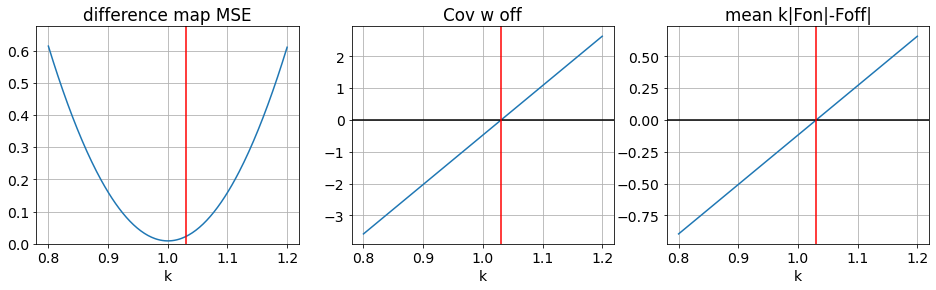

In [16]:
plt.figure(figsize=(16,4))
ax=plt.subplot(1,3,1)
ax.plot(k_range,MSE_obs)
plt.axvline(x=k_expected,color='r')
ax.set_ylim([0, 1.1*np.amax(MSE_obs)])
ax.set_xlabel('k')
ax.set_title('difference map MSE')
plt.grid()

ax=plt.subplot(1,3,2)
plt.plot(k_range,cov_off_obs)
plt.axhline(color='k')
plt.axvline(x=k_expected,color='r')
ax.set_xlabel('k')
ax.set_title('Cov w off')
plt.grid()

ax=plt.subplot(1,3,3)
plt.plot(k_range,mean_DoM)
plt.axhline(color='k')
plt.axvline(x=k_expected,color='r')
ax.set_xlabel('k')
ax.set_title('mean k|Fon|-Foff|')
plt.grid()
plt.show()

The proposed correction factor is not perfect, but does a generally good job of removing covariance with the OFF map with limited hit to difference map accuracy, as measured by MSE with the true difference map.

The correction factor is a complicated function of $|E^{off}|, p, r_{DW}$. As we saw previously, the latter is a function of resolution. In other words, it may be simplest to find, instead, a function, such as a neural network, that encodes $k$, predicting $|E^{on}|$ from $|E^{off}|$ and $d_{hkl}$ using mean-squared error as a loss function. 

#### Expected MSE
A byproduct of the above calculation is that we can determine the MSE map error for the proposed $k(|E^{off}|, p, r)$ as a function of its arguments. This can be a consideration in the determination of map weights.

In [17]:
def generate_dw_samples(rx, E_gs, nmax):
    mean= rx * np.asarray([np.real(E_gs),np.imag(E_gs)])
    cov = 0.5*np.asarray([[ 1-rx**2,        0],\
                          [0,        1 -rx**2]])
    vals  = rng.multivariate_normal(mean,cov,nmax)
    return vals

class on_off_samples:
  def __init__(self, vals, E_gs, p):
    self.E_gs     = E_gs
    self.E_es     = vals[:,0] + 1j * vals[:,1]
    self.E_off    = E_gs
    self.E_on     = (1-p)*E_gs + p*self.E_es
    self.phi_on   = np.angle(self.E_off)
    self.phi_off  = np.angle(self.E_on)
    self.E_off_abs = np.abs(self.E_off)
    self.E_on_abs  = np.abs(self.E_on)

def calc_correction_factor(E_gs, p, rx):
    cond_mean   = np.abs(E_gs) * (1-p*(1-rx))
    nu          = cond_mean            
    cond_var_ac = 0.5*p**2*(1-rx**2)
    sigma_ac    = np.sqrt(cond_var_ac) 
    k_expected = np.abs(E_gs)/rice.mean(b=nu/sigma_ac, scale=sigma_ac)
    if np.isnan(k_expected):
        k_expected = np.abs(E_gs)/rice_mean(nu,sigma_ac)
#     if np.isnan(k_expected):
#         print(nu)
#         print(sigma_ac)
    return k_expected

nmax_p, nmax_r, nmax_E = (11,11,16)
p_range    = np.linspace(0.01,0.5, nmax_p)
r_range    = np.linspace(0.8,0.98, nmax_r)
E_gs_range = np.linspace(0.25, 3, nmax_E)
MSE_obs    = np.zeros((nmax_p, nmax_r, nmax_E))
MSE_obs_2d = np.zeros((nmax_p * nmax_r * nmax_E,3))
n=0
for ix_p in range(nmax_p):
    for ix_r in range(nmax_r):
        for ix_E in range(nmax_E):
            p, rx, E_gs, nmax = (p_range[ix_p], r_range[ix_r], E_gs_range[ix_E], 10000)
            delta = p*(1-rx)
            y = on_off_samples(generate_dw_samples(rx, E_gs, nmax), E_gs, p)
            MSE_obs[ix_p, ix_r, ix_E] = calc_MSE([calc_correction_factor(E_gs, p, rx),1], y.E_on_abs, y.phi_off, y.E_off_abs, y.E_es, y.E_gs)
            MSE_obs_2d[n,0] = delta
            MSE_obs_2d[n,1] = E_gs
            MSE_obs_2d[n,2] = MSE_obs[ix_p, ix_r, ix_E]
            n = n+1
MSE_obs[MSE_obs>0.3]=0
print("Done")

C:\Users\Doeke Hekstra\.conda\envs\crystallography\lib\site-packages\scipy\stats\_continuous_distns.py:6879: RuntimeWarning: invalid value encountered in multiply
  return (2.0**(nd2) * np.exp(-b2) * sc.gamma(n1) *
<ipython-input-14-a298fb850818>:2: RuntimeWarning: invalid value encountered in double_scalars
  result = np.exp(x/2)*((1-x)*i0(-x/2)-x*i1(-x/2))
<ipython-input-14-a298fb850818>:2: RuntimeWarning: overflow encountered in double_scalars
  result = np.exp(x/2)*((1-x)*i0(-x/2)-x*i1(-x/2))


Done


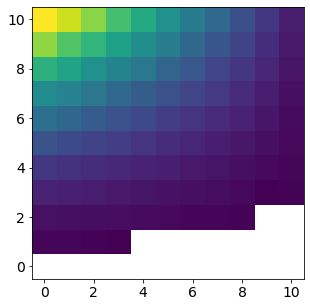

In [18]:
plt.figure(figsize=(8,5))
plt.imshow(MSE_obs[:,:,5],origin='lower')#,extent = (E_gs_range[0],E_gs_range[-1], r_range[0],r_range[-1]),aspect=10)
plt.xlabel("")
plt.ylabel("")
# plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


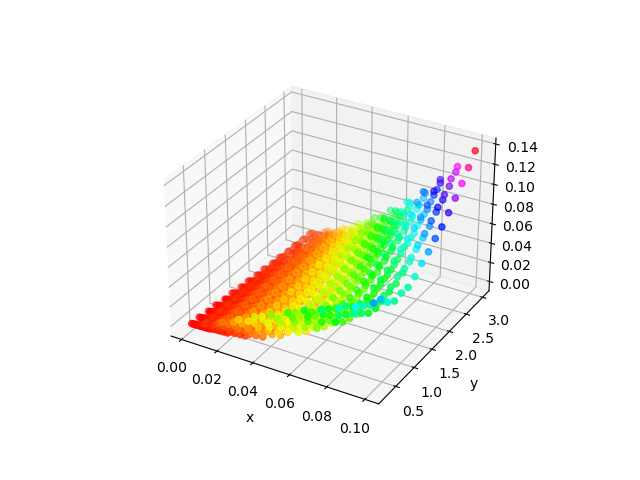

In [20]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection="3d")

bmask = MSE_obs_2d[:,2]<0.18
ax.scatter3D(MSE_obs_2d[bmask,0],MSE_obs_2d[bmask,1],MSE_obs_2d[bmask,2], c=MSE_obs_2d[bmask,2], cmap='hsv')
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.show()

The nice thing about the above plot is that the MSE is in pretty good approximation a function of two rather than three parameters (collapsing $p$ and $r$ into $p(1-r)$). And, we can estimate both. (Another observation: we expect bias and map coefficient error to be correlated quite well).

To do: assess the role of measurement errors.

### The role of measurement error
A direct extension of the calculation of MSE map error above with additive noise terms for $|F^{on}|$ and $|F^{off}|$, shows that 

$$MSE_{meas.\  error} = MSE_{ideal} + k^2 \sigma^2_{on} + \sigma^2_{off}$$

as can be seen by setting, for simplicity, the phase of $F_{off}$ to zero and adding the noise terms to the calculation of $\Delta A$ and assuming statistical independence between ground-state/excited-state differences and measurement errors. This provides a simple recipe for including measurement error in weight calculations:

$$w_{hkl}=\frac{1}{MSE_{ideal} + k^2 \sigma^2_{on} + \sigma^2_{off}}$$

In [71]:
def calc_MSE_w_meas_error(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, on_error, off_error, scale_by_p=True):
    '''
    As described above, this function calculates the expected mean square error (MSE) between a naive estimator 
    of the difference map and the true difference map. 
    '''
    if scale_by_p:
        pscale = p
    else:
        pscale = 1
    
    deltaF_off_phased = (k[0]*(E_on_abs+on_error) - k[1]*(E_off_abs+off_error))*np.exp(1j*phi_off)
    MSE = np.mean(np.abs(deltaF_off_phased - pscale*(E_es-E_gs))**2)
    return MSE

def calc_Cov_off_w_meas_error(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, on_error, off_error):
    deltaF_off_phased = (k[0]*(E_on_abs+on_error) - k[1]*(E_off_abs+off_error))*np.exp(1j*phi_off)
    Cov_off = np.mean(np.real(deltaF_off_phased) * np.real(E_gs)+\
                      np.imag(deltaF_off_phased) * np.imag(E_gs)\
                     )
    norm1 = np.mean(np.abs(deltaF_off_phased)**2)
    norm2 = np.mean(np.abs(E_gs)**2)
    return [Cov_off, Cov_off/(np.sqrt(norm1*norm2))]

def calc_Corr_true_w_meas_error(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, on_error, off_error):
    deltaF_off_phased = (k[0]*(E_on_abs+on_error) - k[1]*(E_off_abs+off_error))*np.exp(1j*phi_off)
    Cov_true = np.mean(np.real(deltaF_off_phased) * np.real(E_es-E_gs)+\
                      np.imag(deltaF_off_phased) * np.imag(E_es-E_gs)\
                     )
    norm1 = np.mean(np.abs(deltaF_off_phased)**2)
    norm2 = np.mean(np.abs(E_es-E_gs)**2)
    return Cov_true/(np.sqrt(norm1*norm2))

### Let's repeat our 2D optimization with meas error

In [156]:
rng  = default_rng()
rx   = 0.95
p    = 0.2
E_gs = 0.5 + 1j*0

mean= rx * np.asarray([np.real(E_gs),np.imag(E_gs)])
cov = 0.5*np.asarray([[ 1-rx**2,        0],\
                      [0,        1 -rx**2]])
vals  = rng.multivariate_normal(mean,cov,10000)

E_es   = vals[:,0] + 1j * vals[:,1]
E_off  = E_gs
E_on   = (1-p)*E_gs + p*E_es
phi_on = np.angle(E_off)
phi_off= np.angle(E_on)
E_off_abs = np.abs(E_off)
E_on_abs  = np.abs(E_on)

In [163]:
sig_off = 0.0707
sig_on  =  0.0707
off_error = sig_off * np.random.normal(size=E_on_abs.shape) # E_off_abs is a scalar!
on_error  = sig_on  * np.random.normal(size=E_on_abs.shape )

nmax = 100
nmax2 = nmax # Used for validating image axes
MSE_obs     = np.zeros((nmax,nmax2))
corr_off_obs = np.zeros((nmax,nmax2))
corr_true   = np.zeros((nmax,nmax2))
mean_DoM    = np.zeros((nmax,nmax2))
k1_range = np.linspace(0.9,1.1,nmax)/p
k2_range = np.linspace(0.9,1.1,nmax2)/p
for k1 in tqdm(range(0,nmax)):
    for k2 in range(0,nmax2):
        k = [k1_range[k1],k2_range[k2]]
        MSE_obs[    k1,k2] = calc_MSE_w_meas_error(      k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, on_error, off_error,\
                                                   scale_by_p=False)
        corr_off_obs[k1,k2] = calc_Cov_off_w_meas_error(  k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, on_error, off_error)[1]
        corr_true[k1,k2]    = calc_Corr_true_w_meas_error(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, on_error, off_error)

100%|████████████████████████████████████████| 100/100 [00:18<00:00,  5.55it/s]


1.0035798287318332


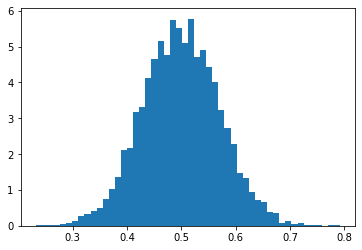

In [164]:
plt.hist(E_off_abs+off_error,bins=50, density=True)

k_emp = np.mean(E_off_abs + off_error)/np.mean(E_on_abs + on_error)
print(k_emp)

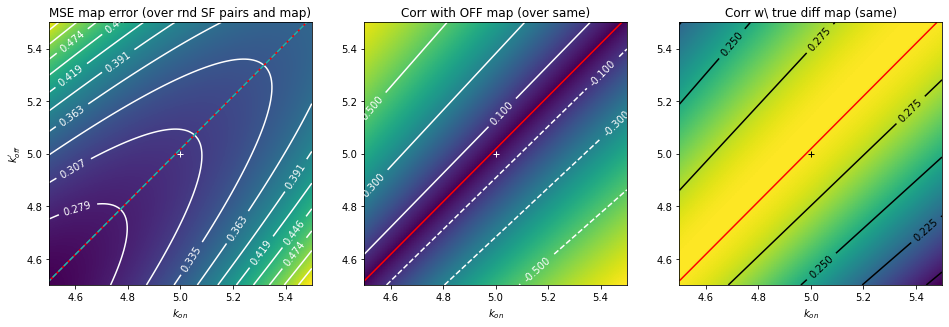

In [165]:
%matplotlib inline
fig, _axs = plt.subplots(nrows=1, ncols=3,figsize=(16,5))
extent = [k1_range[0], k1_range[-1], k2_range[0], k2_range[-1]]
axs = _axs.flatten()

axs[0].imshow(      MSE_obs, origin='lower', extent=extent)
cs = axs[0].contour(MSE_obs, levels=np.linspace(0,np.amax(MSE_obs.flatten()),21),colors='w', extent=extent)
axs[0].clabel(cs, inline=True, fontsize=10)
axs[0].plot(1/p,1/p,'w+')
axs[0].plot(k_range[[0,-1]], k_emp * k_range[[0,-1]],'c--')
axs[0].set_title("MSE map error (over rnd SF pairs and map)")
axs[0].set_xlabel(r"$k_{on}$")
axs[0].set_ylabel(r"$k_{off}'$")
axs[0].set_xlim(k1_range[[0,-1]])
axs[0].set_ylim(k2_range[[0,-1]])

axs[1].imshow( np.abs(corr_off_obs), origin='lower', extent=extent)
cs=axs[1].contour(corr_off_obs,levels=np.linspace(-0.5,0.5,6),colors='w', extent=extent)
axs[1].clabel(cs, inline=True, fontsize=10)
axs[0].contour(corr_off_obs,levels=[0],colors='r', extent=extent)
axs[1].contour(corr_off_obs,levels=[0],colors='r', extent=extent)
axs[1].plot(1/p,1/p,'w+')
# axs[1].plot(k_range, 1.0293*k_range,'k:')
axs[1].set_title("Corr with OFF map (over same)")
axs[1].set_xlabel(r"$k_{on}$")
axs[1].set_xlim(k1_range[[0,-1]])
axs[1].set_ylim(k2_range[[0,-1]])
# plt.scatter(cov_off_obs[np.abs(cov_off_obs<0.002)][:,0], cov_off_obs[np.abs(cov_off_obs<0.002)][:,1],'k.')
# plt.colorbar()

axs[2].imshow( corr_true, origin='lower', extent=extent)
cs=axs[2].contour(corr_true,levels=np.linspace(-1,1,81),colors='k', extent=extent)
axs[2].clabel(cs, inline=True, fontsize=10)
axs[2].contour(corr_off_obs,levels=[0],colors='r', extent=extent)
axs[2].plot(1/p,1/p,'k+')
# axs[1].plot(k_range, 1.0293*k_range,'k:')
axs[2].set_title("Corr w\ true diff map (same)")
axs[2].set_xlabel(r"$k_{on}$")
# axs[2].set_xlim(k_range[[0,-1]])
# axs[2].set_ylim(k_range[[0,-1]])
plt.show()

tbd

In [ ]:
# The following cell tests this but is not particularly useful yet.
nmax_p, nmax_r, nmax_E, nmax_s = (11,11,16,11)
p_range    = np.linspace(0.01,0.5, nmax_p)
r_range    = np.linspace(0.8,0.98, nmax_r)
E_gs_range = np.linspace(0.25, 3, nmax_E)
sigE_range = np.linspace(0,0.5,nmax_s)
MSE_obs    = np.zeros((nmax_p, nmax_r, nmax_E, nmax_s))
MSE_obs_2d = np.zeros((nmax_p * nmax_r * nmax_E * nmax_s,3))
n=0
for ix_p in range(nmax_p):
    print(ix_p)
    for ix_r in range(nmax_r):
        for ix_E in range(nmax_E):
            for ix_s in range(nmax_s):
                p, rx, E_gs, sigE, nmax = (p_range[ix_p], r_range[ix_r], E_gs_range[ix_E], sigE_range[ix_s], 10000)
                delta = p*(1-rx)
                y = on_off_samples(generate_dw_samples(rx, E_gs, nmax), E_gs, p)
                MSE_obs[ix_p, ix_r, ix_E, ix_s] = calc_MSEw_meas_error([calc_correction_factor(E_gs, p, rx),1], \
                                                                 y.E_on_abs, y.phi_off, y.E_off_abs, y.E_es, y.E_gs,\
                                                                 sigE, sigE)
                MSE_obs_2d[n,0] = delta
                MSE_obs_2d[n,1] = sigE_range[ix_s]
                MSE_obs_2d[n,2] = MSE_obs[ix_p, ix_r, ix_E, ix_s]
                n = n+1
# MSE_obs[MSE_obs>0.3]=0
print("Done")

Note that we are neglecting the effect, if any, of errors in |F^{off}| on $k$.

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection="3d")

bmask = MSE_obs_2d[:,2]<0.18
ax.scatter3D(MSE_obs_2d[bmask,0],MSE_obs_2d[bmask,1]**2,MSE_obs_2d[bmask,2], c=MSE_obs_2d[bmask,2], cmap='hsv')
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.show()

## Posterior probability for excited state structure factors given $|E^{on}|$ and $|E^{off}|$

Complex $E^{on}$ conditional on $E^{off}=(|E^{off}|,0)$ with $\phi^{off}=0$, without loss of generality, follows a bivariate normal with mean $\left<E^{on}\right>=|E^{off}|(1-p+p\cdot r_{DW})$ and covariance $\frac{1}{2}p^2(1-r_{DW}^2)I$ under the Coppens random-diffuse model. Hence, $|E^{on}|$ follows $Rice\left(\nu=|E^{off}|(1-p+p\cdot r_{DW}), \sigma^2=\frac{1}{2}p^2(1-r_{DW}^2)\right)$. It's expectation value is given on https://en.wikipedia.org/wiki/Rice_distribution.

As a consequence, we can directly determine the posterior probability of $E^{es}$ given $|E^{on}|$ and $|E^{off}|$. This is very exciting, as $P\left(E^{es}\right)$ is a natural starting point for excited state refinement.

Specifically,

\begin{align}
P\left(E^{es}\Bigr| |E^{on}|, E^{off}\right) 
    & =\frac{P\left(E^{es}, |E^{on}|\Bigr| E^{off}\right)}{P\left(|E^{on}|\Bigr| E^{off}\right)}\\
    & =\frac{P\left(|E^{on}|\Bigr| E^{es}, E^{off}\right) P\left(E^{es}\Bigr| E^{off}\right)}{P\left(|E^{on}|\Bigr| E^{off}\right)}\\
     & =\frac{P\left(E^{es}\Bigr| E^{off}\right)}{P\left(|E^{on}|\Bigr| E^{off}\right)}\delta\left(
         |E^{on}|-|pE^{es}+(1-p)E^{off}|
     \right)\\
\end{align}

Assuming we know $p$, and, indeed, $|E^{on}|,|E^{off}|$, we can evaluate this expression.